In [1]:
import tensorflow as t
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
# Replace the existing import
# from tensorflow.losses import sparse_softmax_cross_entropy

# With the updated import
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy


In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50 # its a trail and error

In [3]:
dataset=t.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle=True,
    image_size=( IMAGE_SIZE,IMAGE_SIZE),
     batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) #each batch contain 32 images 32*68 =2176 approx(near to the 2152) 

68

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    #32 images in 1 batch
    #256 x and y
    # 3 is RGB

(32, 256, 256, 3)
[0 0 0 1 0 0 1 2 0 0 1 0 2 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 2 1 0 0]


In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)
    

(256, 256, 3)


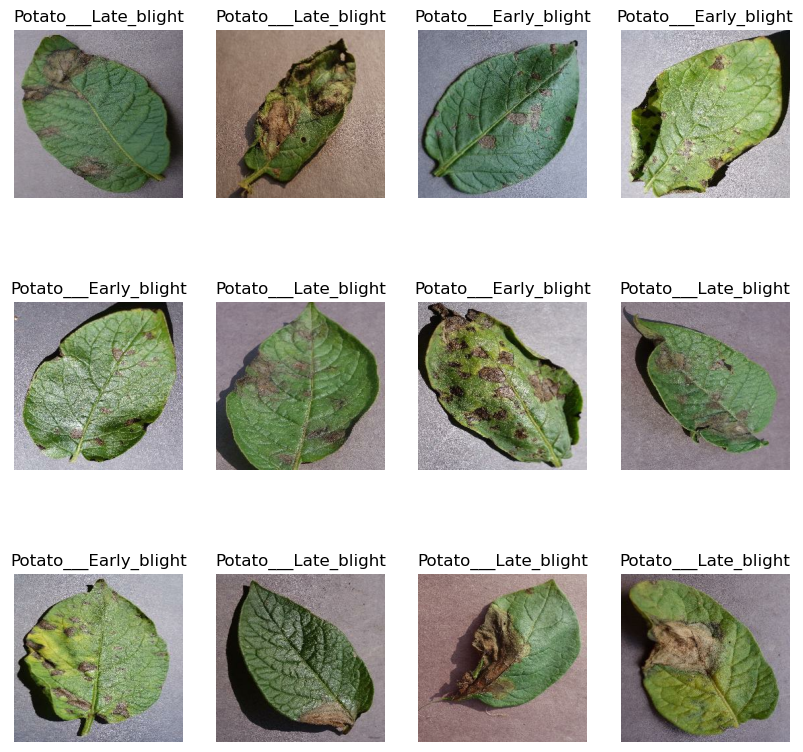

In [20]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    # for every run of the current cell image will shuffle 

80% ==> training
20% ==> 10% validation,10% test

In [8]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds=dataset.take(54)
len(train_ds)

54

In [10]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
   
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
     
    return train_ds,val_ds,test_ds

In [15]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=t.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=t.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=t.data.AUTOTUNE)

In [20]:
resize_and_rescale=t.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation=t.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes =3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [24]:
model.compile(
    optimizer='adam',
    loss=t.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


 2/54 [>.............................] - ETA: 2:06 - loss: 10.6213 - accuracy: 0.4844

In [50]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 292ms/step - loss: 0.0509 - accuracy: 0.9727


In [51]:
scores

[0.050857968628406525, 0.97265625]

In [52]:
history

In [53]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [54]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [55]:
history.history['accuracy']

[0.5034722089767456,
 0.7268518805503845,
 0.8148148059844971,
 0.8859953880310059,
 0.8917824029922485,
 0.9126157164573669,
 0.9074074029922485,
 0.9380787014961243,
 0.9403935074806213,
 0.9351851940155029,
 0.9357638955116272,
 0.9317129850387573,
 0.9403935074806213,
 0.9583333134651184,
 0.9369212985038757,
 0.9421296119689941,
 0.9409722089767456,
 0.9525462985038757,
 0.9461805820465088,
 0.9427083134651184,
 0.9542824029922485,
 0.9652777910232544,
 0.9513888955116272,
 0.9548611044883728,
 0.9583333134651184,
 0.9641203880310059,
 0.9664351940155029,
 0.9646990895271301,
 0.9623842835426331,
 0.9490740895271301,
 0.9554398059844971,
 0.9762731194496155,
 0.9484953880310059,
 0.9594907164573669,
 0.9594907164573669,
 0.9716435074806213,
 0.9635416865348816,
 0.9652777910232544,
 0.9623842835426331,
 0.9693287014961243,
 0.9785879850387573,
 0.9728009104728699,
 0.96875,
 0.9791666865348816,
 0.9797453880310059,
 0.9803240895271301,
 0.9751157164573669,
 0.9699074029922485,
 0.

In [56]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

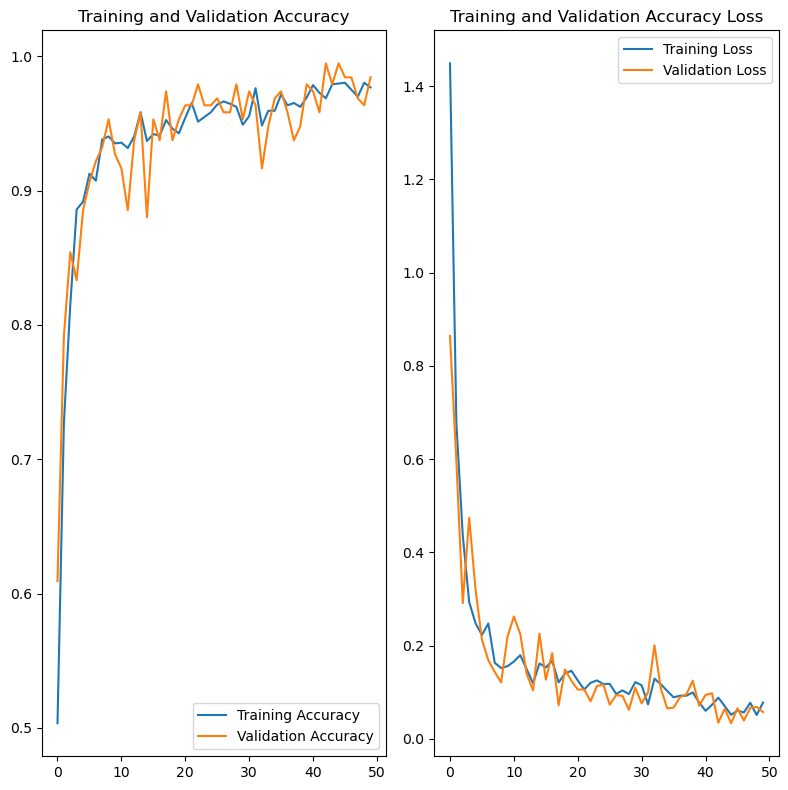

In [59]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy Loss')
plt.tight_layout()
plt.show()

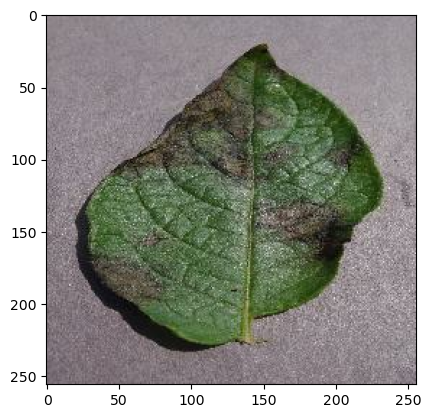

In [63]:
for images_batch,labels_batch in test_ds.take(1):

     plt.imshow(images_batch[0].numpy().astype('uint8'))

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 987ms/step
[8.966722e-04 9.990941e-01 9.219155e-06]


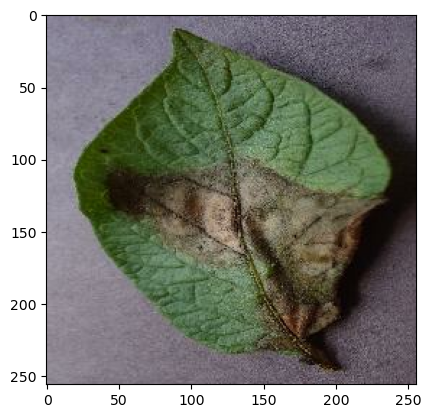

In [74]:
for images_batch,labels_batch in test_ds.take(1):

     first_image=images_batch[0].numpy().astype('uint8')
     first_label=labels_batch[0].numpy()
    
     print("first image to predict")
     plt.imshow(first_image)
    
     print("actual label:",class_names[first_label])

     batch_prediction=model.predict(images_batch)
     print(batch_prediction[0])

In [76]:
#np.argmax([8.966722e-04, 9.990941e-01,9.219155e-06])

1

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 343ms/step
predicted label: Potato___Late_blight


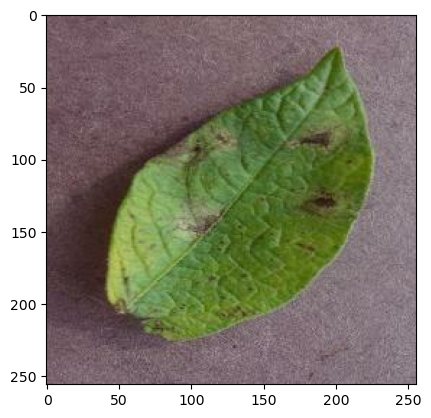

In [78]:
for images_batch,labels_batch in test_ds.take(1):

     first_image=images_batch[0].numpy().astype('uint8')
     first_label=labels_batch[0].numpy()
    
     print("first image to predict")
     plt.imshow(first_image)
     print("actual label:",class_names[first_label])

     batch_prediction=model.predict(images_batch)
     print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [86]:
def predict(model, img):
     img_array = t.keras.preprocessing.image.img_to_array(images[i].numpy()) 
     img_array = t.expand_dims(img_array, 0) # Create a batch

     predictions = model.predict(img_array)

     predicted_class = class_names[np.argmax(predictions[0])] 
     confidence = round(100 *(np.max(predictions[0])), 2) 
     return predicted_class, confidence

1/1 [==============================] - 0s 63ms/step


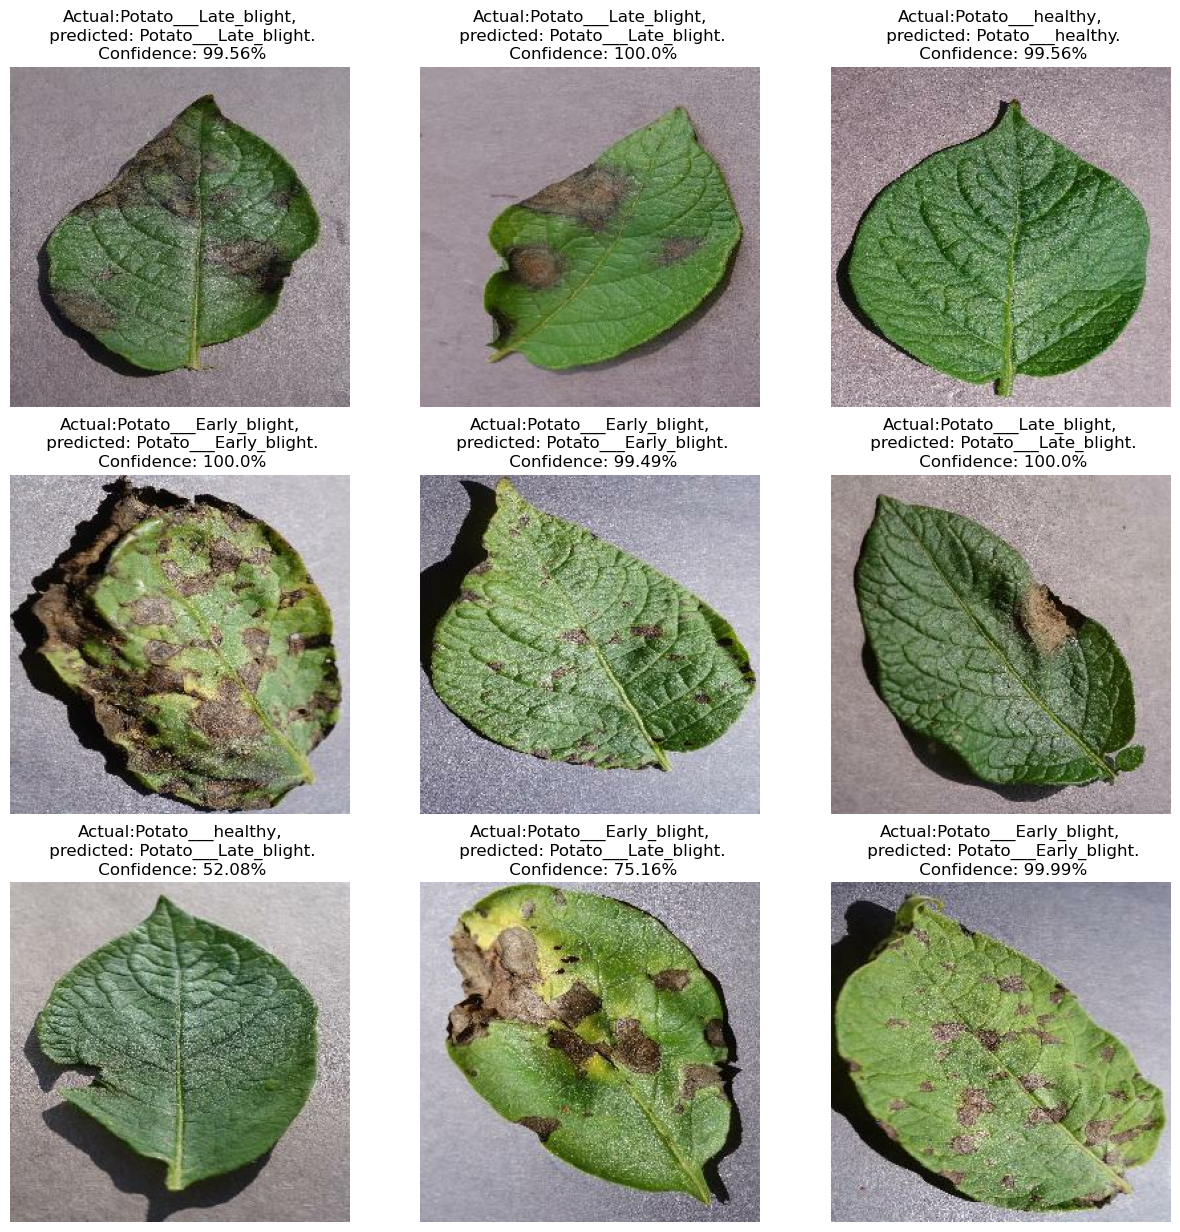

In [93]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1): 
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")